# ⚡ Modelado TIER 1: LightGBM

> **Objetivo**: Entrenar y evaluar un modelo LightGBM para predecir **nombres de fertilizantes** basado en condiciones de suelo y cultivo.
> 
> **Variable Objetivo**: `Fertilizer Name` (nombres de fertilizantes codificados)
> 
> **Estrategia**: Usar LightGBM como modelo avanzado de gradient boosting debido a su alta eficiencia, precisión y capacidad de manejo de features categóricas para problemas de clasificación multiclase.
> 
> **Métrica Principal**: MAP@3 (Mean Average Precision at 3) - requerida por la competencia de Kaggle

---

## 📚 1. Carga de Librerías y Datos

### Importación de librerías necesarias y carga de datos preprocesados

In [10]:
# Librerías principales
import pandas as pd
import numpy as np
import pickle
import joblib

# Utilidades del proyecto
import sys
sys.path.append('../src')
from model_utils import ModelTrainer, print_feature_selection_summary, print_training_config, show_prediction_examples
from visuals import plot_confusion_matrix, plot_probability_analysis, plot_predictions_vs_actual, plot_top3_accuracy_analysis, plot_feature_importance
from metrics import mapk

# LightGBM
import lightgbm as lgb

In [11]:
# Inicializar trainer y cargar datos
trainer = ModelTrainer('LGBMClassifier', 'LGBM')
data = trainer.load_data()

# Extraer datasets
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test = data['X_test']
feature_info = data['feature_info']
label_encoders = data['label_encoders']
fertilizer_encoder = label_encoders['Fertilizer Name']

print("Datos cargados exitosamente:")
print(f"  • Variable objetivo: {y_train.name}")

📂 Cargando datos preprocesados...
✅ Datos cargados: Train(600000, 32), Val(150000, 32), Test(250000, 32)
Datos cargados exitosamente:
  • Variable objetivo: Fertilizer Name_encoded


## 🎯 2. Selección de Features

### Definiendo las características que utilizaremos para el modelo

In [12]:
# =============================================================================
# SELECCIÓN DE FEATURES PARA EL MODELO
# =============================================================================

features_to_use = [
    # 🌡️ VARIABLES CLIMÁTICAS ORIGINALES
    'Temparature',
    'Humidity', 
    'Moisture',
    
    # 🌱 VARIABLES DE SUELO Y CULTIVO
    # 'Soil Type',
    # 'Crop Type',
    
    # 🧪 VARIABLES QUÍMICAS (NPK)
    'Nitrogen',
    'Potassium', 
    'Phosphorous',
    
    # # 📊 FEATURES ENGINEERED - RATIOS NPK
    # 'N_P_ratio',
    # 'N_K_ratio',
    # 'P_K_ratio',
    # 'Total_NPK',
    
    # # 🌡️ FEATURES ENGINEERED - ÍNDICES CLIMÁTICOS
    # 'Temp_Hum_index',
    # 'Moist_Balance',
    # 'Environ_Stress',
    
    # # 🏷️ FEATURES ENGINEERED - CATEGORÍAS
    # 'Temp_Cat',
    # 'Hum_Cat',
    # 'N_Level',
    # 'K_Level',
    # 'P_Level',
    
    # # 🔗 FEATURES ENGINEERED - COMBINACIONES
    # 'Soil_Crop_Combo',
    # 'NPK_Balance',
    # 'Dominant_NPK_Level',
    # 'Temp_Moist_inter',
    
    # # 🔢 FEATURES ENCODED (CATEGÓRICAS)
    # 'Soil Type_encoded',
    # 'Crop Type_encoded',
    # 'Temp_Cat_encoded',
    # 'Hum_Cat_encoded',
    # 'N_Level_encoded',
    # 'K_Level_encoded',
    'P_Level_encoded',
    'Soil_Crop_Combo_encoded'
]

# Validar features disponibles
features_to_use = trainer.validate_features(features_to_use, X_train)
print_feature_selection_summary(features_to_use, features_to_use)

✅ Features válidas: 8
🎯 FEATURES SELECCIONADAS: 8
   1. Temparature
   2. Humidity
   3. Moisture
   4. Nitrogen
   5. Potassium
   6. Phosphorous
   7. P_Level_encoded
   8. Soil_Crop_Combo_encoded


## ⚙️ 3. Configuración de Hiperparámetros

### Definiendo los parámetros del modelo LightGBM

In [13]:
# =============================================================================
# CONFIGURACIÓN DE HIPERPARÁMETROS - BASELINE OPTIMIZADA
# =============================================================================

lgbm_params = {
    "objective": "multiclass",
    "num_class": len(fertilizer_encoder.classes_),
    "boosting_type": "gbdt",
    "num_leaves": 50,
    "learning_rate": 0.010,
    "n_estimators": 800,
    "max_depth": 8,
    "min_child_samples": 10,
    "min_child_weight": 0.001,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 513,
    "n_jobs": -1,
    "class_weight": "balanced",
    "importance_type": "gain",
    "verbose": -1
}

print_training_config(lgbm_params)

⚙️ CONFIGURACIÓN:
  • objective: multiclass
  • num_class: 7
  • boosting_type: gbdt
  • num_leaves: 50
  • learning_rate: 0.01
  • n_estimators: 800
  • max_depth: 8
  • min_child_samples: 10
  • min_child_weight: 0.001
  • subsample: 0.8
  • subsample_freq: 1
  • colsample_bytree: 0.8
  • reg_alpha: 0.1
  • reg_lambda: 0.1
  • random_state: 513
  • n_jobs: -1
  • class_weight: balanced
  • importance_type: gain
  • verbose: -1


## 🚀 4. Entrenamiento del Modelo

### Inicialización y entrenamiento del LightGBM

In [14]:
# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

# Inicializar y entrenar modelo
lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model = trainer.train_model(lgbm_model, X_train, y_train, features_to_use)

🚀 Entrenando LGBMClassifier...


✅ Entrenamiento completado en 448.72s


## 📊 5. Evaluación del Modelo

### Evaluación del rendimiento en el conjunto de validación

In [15]:
# =============================================================================
# EVALUACIÓN DEL MODELO
# =============================================================================

# Evaluar modelo
metrics = trainer.evaluate_model(X_val, y_val, features_to_use)

# Generar predicciones para visualizaciones
y_pred_val = lgbm_model.predict(X_val[features_to_use])
y_pred_proba_val = lgbm_model.predict_proba(X_val[features_to_use])
classes = lgbm_model.classes_
y_pred_top3 = trainer.get_top3_predictions(y_pred_proba_val, classes)

# Mostrar ejemplos de predicciones
# show_prediction_examples(y_val, y_pred_top3, fertilizer_encoder, num_examples=3)

# Variables para visualizaciones
map3_score = metrics['map3_score']
auc_roc = metrics['auc_roc']
accuracy = metrics['accuracy']
precision = metrics['precision']
recall = metrics['recall']
f1 = metrics['f1_score']

📊 Evaluando modelo...
🎯 MAP@3: 0.3203 | AUC-ROC: 0.5654 | Accuracy: 0.1875


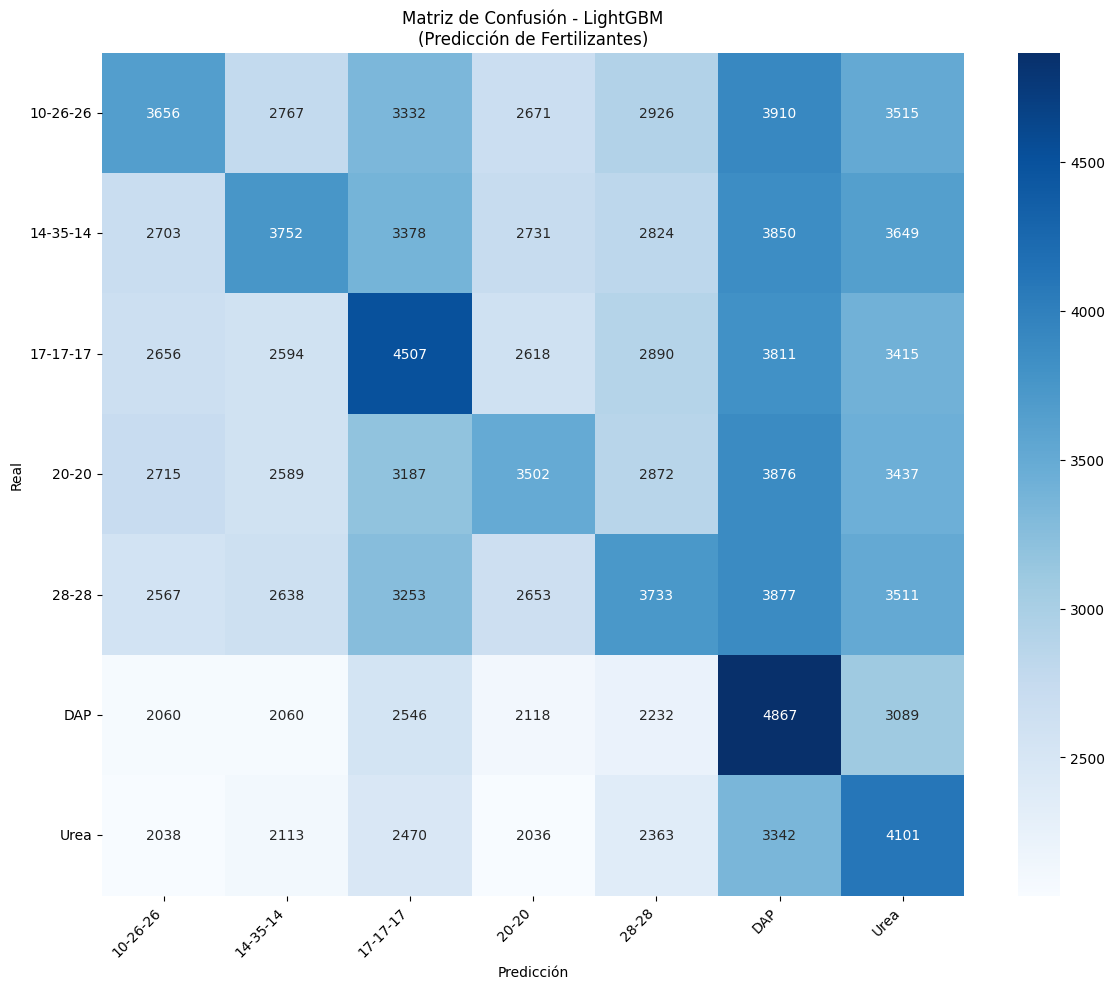

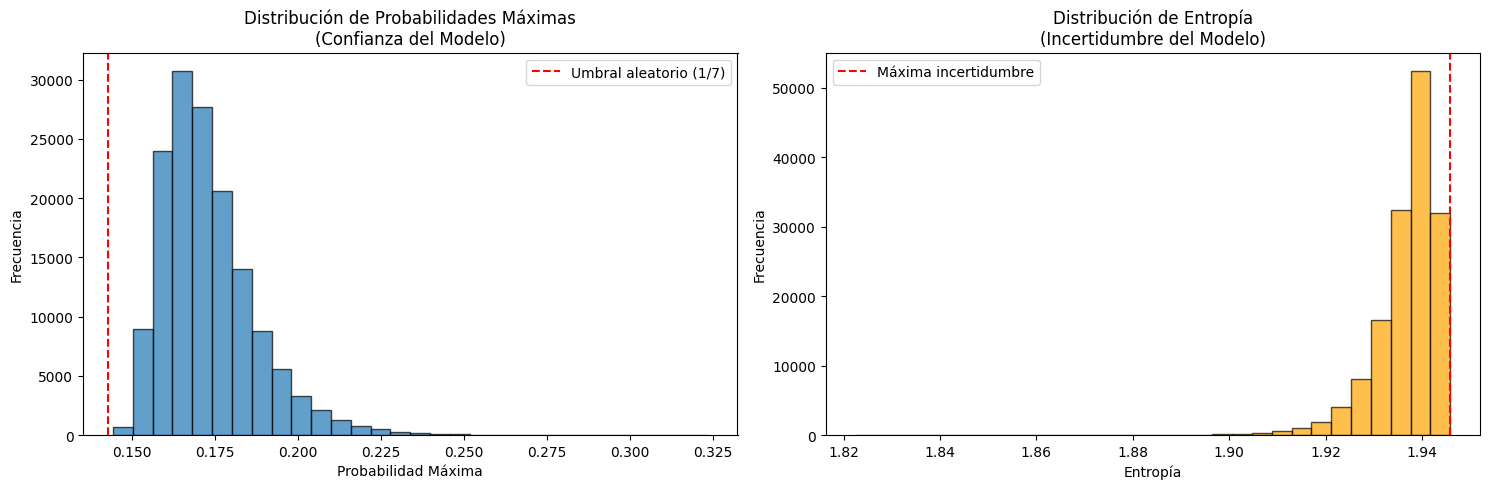

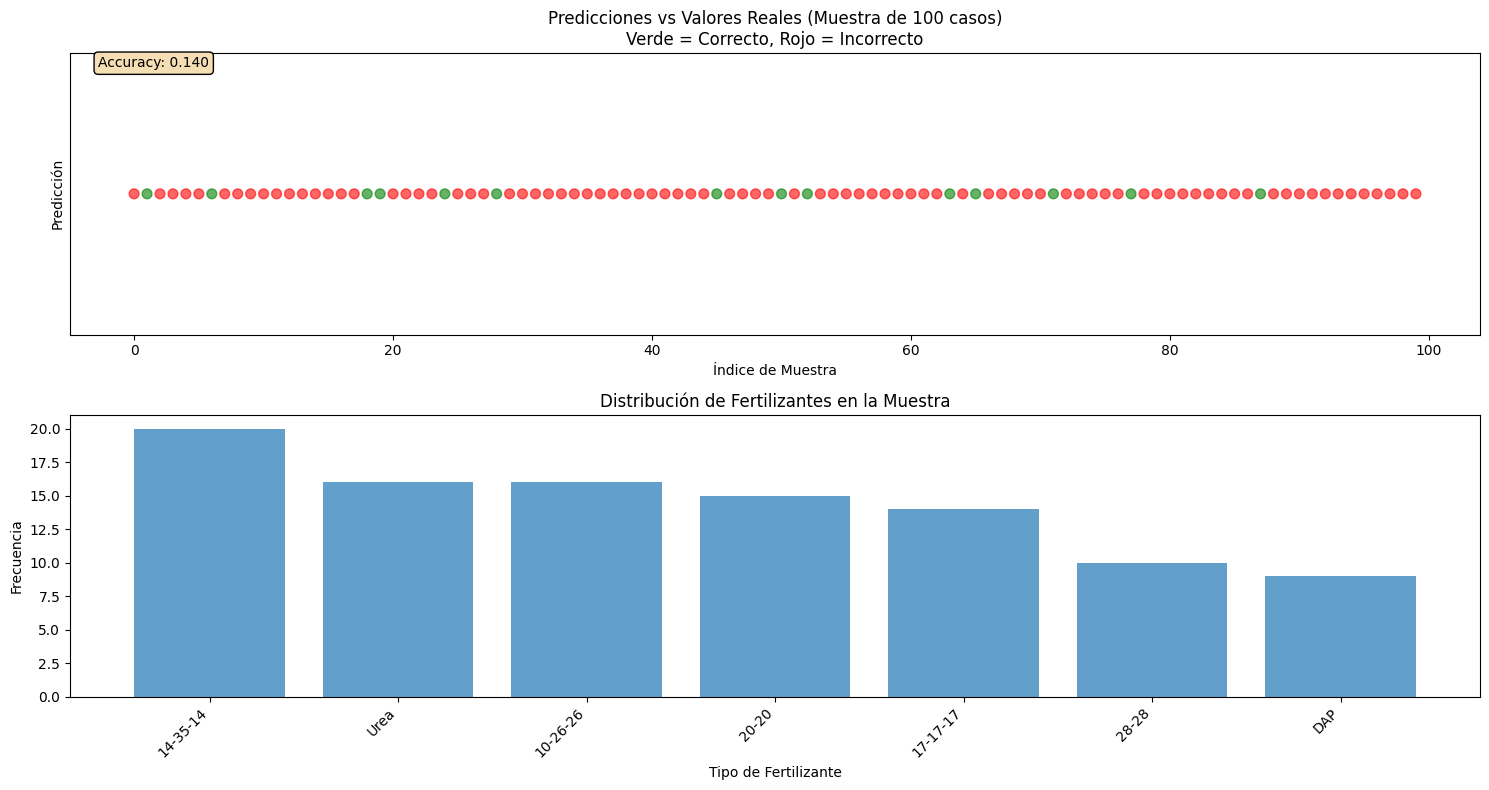

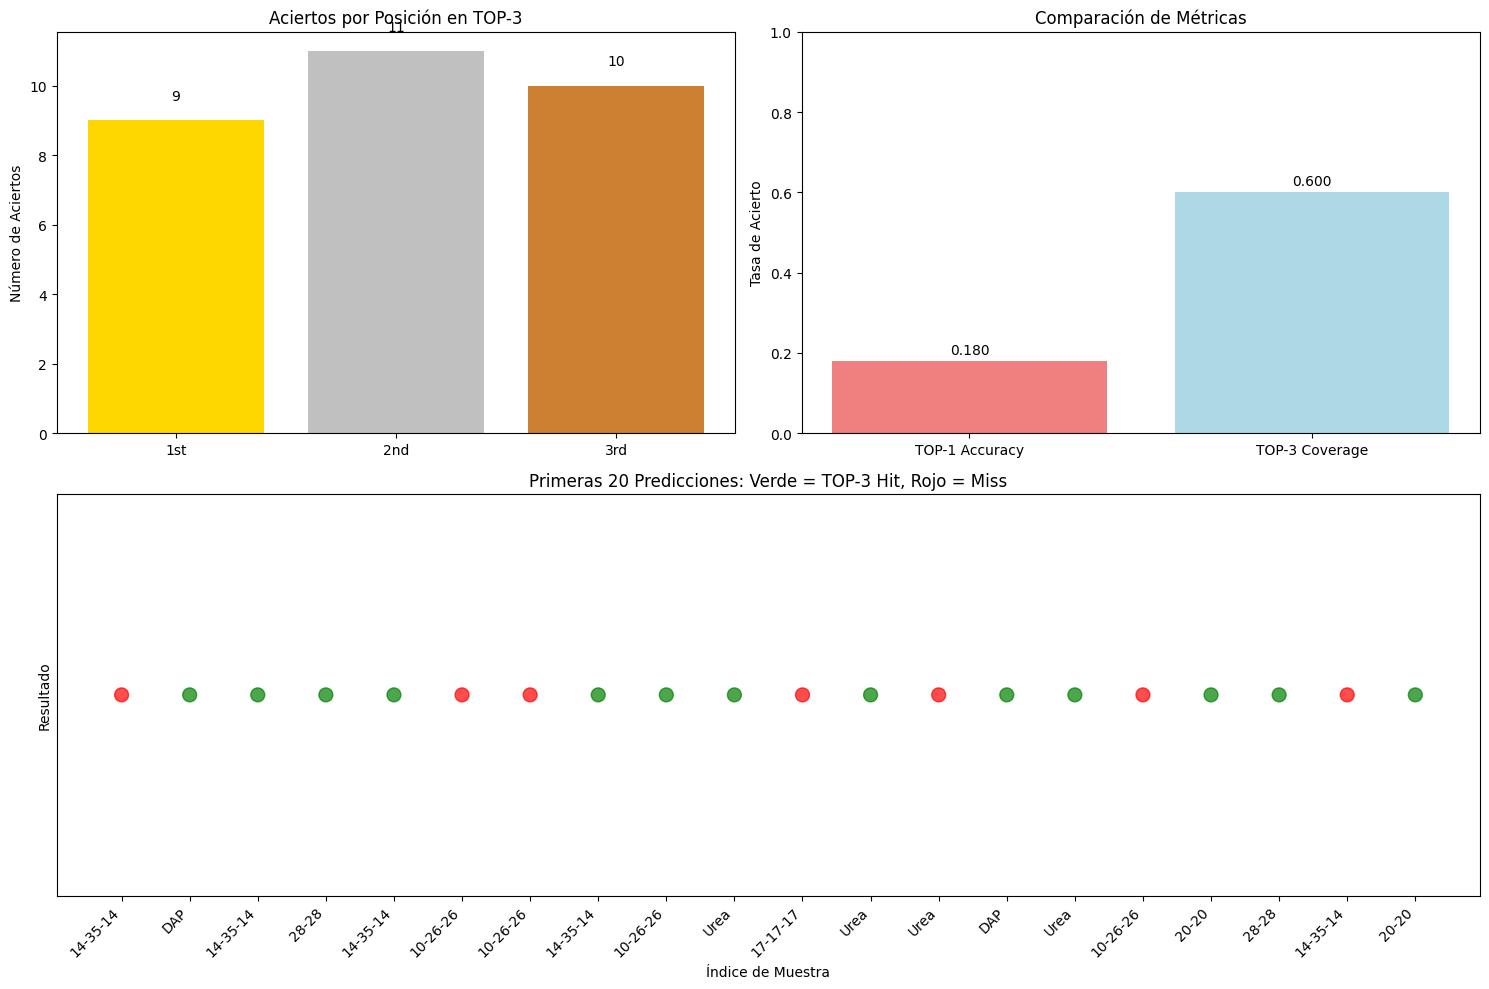


📊 Resumen TOP-3 Analysis:
  • Total samples: 50
  • TOP-3 Coverage: 0.600 (30/50)
  • Position 1 hits: 9 (0.180)
  • Position 2 hits: 11 (0.220)
  • Position 3 hits: 10 (0.200)
✅ Visualizaciones generadas correctamente


In [16]:
# =============================================================================
# VISUALIZACIONES DETALLADAS
# =============================================================================

# Importar funciones de visualización
import sys
sys.path.append('../src')
from visuals import (
    plot_confusion_matrix, 
    plot_probability_analysis, 
    plot_predictions_vs_actual,
    plot_top3_accuracy_analysis,
    plot_feature_importance
)

# 1. Matriz de confusión
fertilizer_names = [fertilizer_encoder.inverse_transform([c])[0] for c in classes]
plot_confusion_matrix(y_val, y_pred_val, fertilizer_names, "Matriz de Confusión - LightGBM")

# 2. Análisis de probabilidades
plot_probability_analysis(y_pred_proba_val, classes)

# 3. Comparación predicciones vs valores reales
comparison_df = plot_predictions_vs_actual(y_val, y_pred_val, fertilizer_encoder, sample_size=100)

# 4. Análisis detallado de TOP-3
top3_analysis = plot_top3_accuracy_analysis(y_val, y_pred_top3, fertilizer_encoder, sample_size=50)

print("✅ Visualizaciones generadas correctamente")

## 💾 6. Guardado del Modelo y Métricas

### Guardado del modelo entrenado y exportación de resultados

💾 Guardando artefactos en: LGBM_MAP@3-03203/
✅ Artefactos guardados en carpeta: LGBM_MAP@3-03203/
🏆 TOP 10 FEATURES MÁS IMPORTANTES:
 1. Soil_Crop_Combo_encoded        408848.9241
 2. Phosphorous                    373841.5416
 3. Moisture                       356529.5579
 4. Nitrogen                       344511.9219
 5. Potassium                      257384.3030
 6. Humidity                       232529.7851
 7. Temparature                    197691.5690
 8. P_Level_encoded                21335.5121


d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='importance', y='feature', ax=ax1, palette='viridis')
d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:261: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:261: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Felix\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Felix\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:

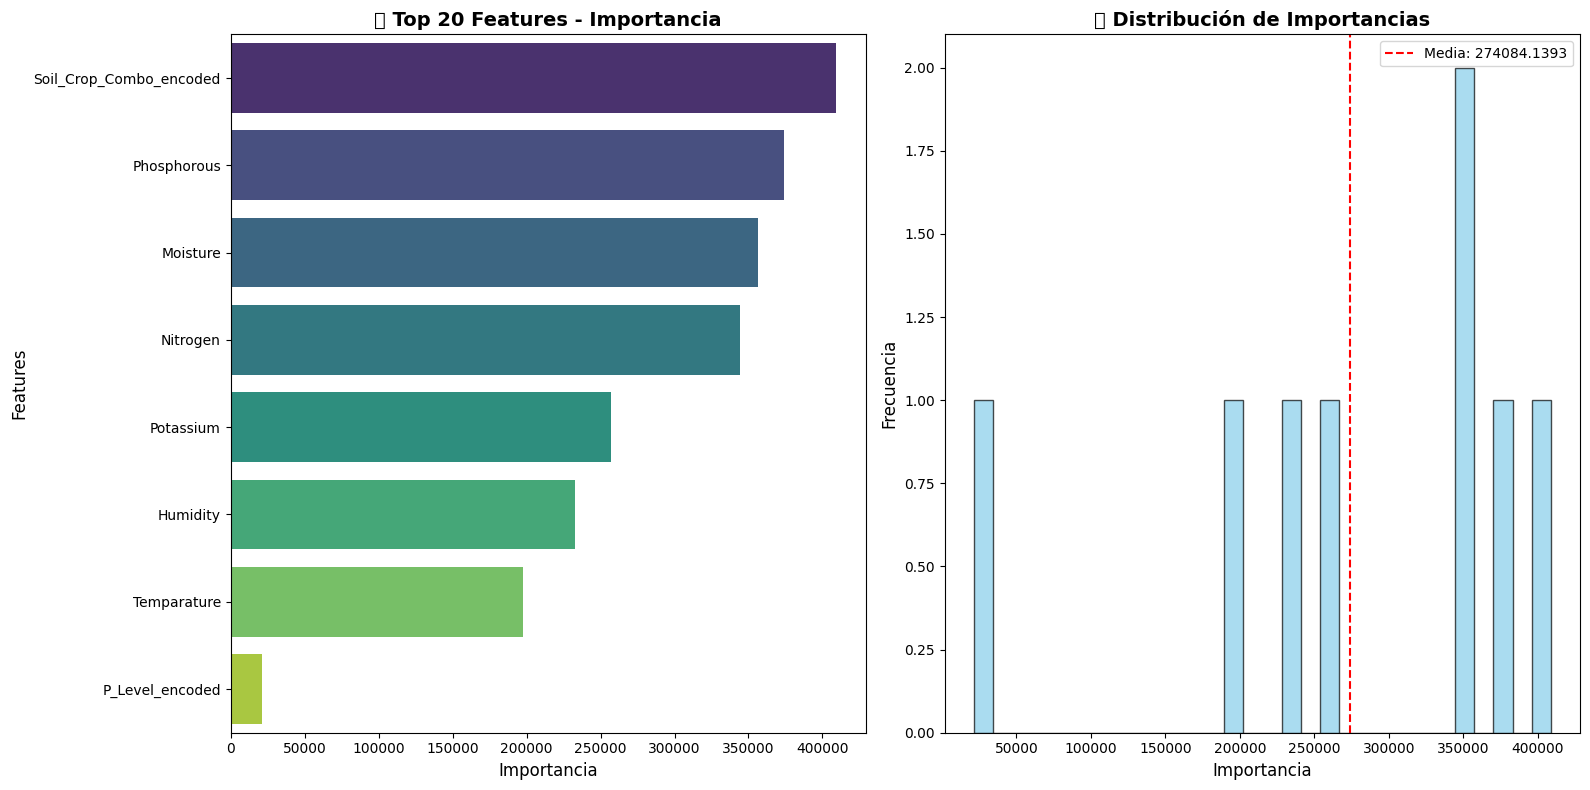


📈 Estadísticas de importancia:
  • Feature más importante: Soil_Crop_Combo_encoded (408848.9241)
  • Importancia promedio: 274084.1393
  • Importancia mediana: 300948.1125
  • Features con importancia > promedio: 4
🔍 Feature importance: LGBM_MAP@3-03203_feature_importance.csv

🎉 RESUMEN - LGBMClassifier
🎯 MAP@3: 0.3203
📊 AUC-ROC: 0.5654
🎯 Features: 8
⏱️ Tiempo: 448.72s


In [17]:
# =============================================================================
# GUARDADO DEL MODELO Y ARTEFACTOS
# =============================================================================

# Guardar todos los artefactos con nomenclatura estandarizada
base_filename = trainer.save_model_artifacts(
    model=lgbm_model,
    metrics=metrics, 
    hyperparams=lgbm_params,
    features=features_to_use
)

# Guardar feature importance
feature_importance_df = plot_feature_importance(
    feature_importances=lgbm_model.feature_importances_,
    feature_names=features_to_use,
    title="Importancia de Features - LightGBM TIER 1"
)

feature_importance_path = f'../models/{base_filename}/{base_filename}_feature_importance.csv'
feature_importance_df.to_csv(feature_importance_path, index=False)
print(f"🔍 Feature importance: {base_filename}_feature_importance.csv")

# Resumen final
trainer.print_summary(features_to_use)

## 📋 8. Generación de Submission (Opcional)

### Predicciones para el conjunto de test y creación del archivo de submission

In [18]:
# =============================================================================
# GENERACIÓN DE SUBMISSION PARA KAGGLE
# =============================================================================

# Generar submission usando el trainer
submission_df = trainer.generate_submission(
    X_test=X_test,
    features=features_to_use,
    label_encoder=fertilizer_encoder,
    base_filename=base_filename
)

# Mostrar muestra del submission
print(f"\n📋 SUBMISSION GENERADO:")
print(f"Formato: {list(submission_df.columns)} | Filas: {len(submission_df)}")

📤 Generando submission...
✅ Submission guardado en: LGBM_MAP@3-03203/

📋 SUBMISSION GENERADO:
Formato: ['id', 'Fertilizer Name'] | Filas: 250000
